# Sistem de fuziune a deciziilor prin ponderare

In [1]:
from FusionSystem import *
import torch
import torch.optim as optim
import torch.nn as nn
from SegDataset import *
from utils.function_lib import *
from utils.DiceLoss import DiceLoss

In [2]:
training_path = 'G:/MachineLearning/liver-database/validation/'

training_dataset = SegDataset(training_path)
training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

device = torch.device('cuda')
fusion_model = FusionSystem(num_sources=4).to(device)
optimizer = optim.SGD(fusion_model.parameters() ,lr=10, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)
loss_fcn = nn.BCEWithLogitsLoss().to(device)

In [3]:
for epoch in range(100):
    print(fusion_model.weights)
    train_loop(training_dataloader, fusion_model, loss_fcn, optimizer, scheduler=None,  device=device)
    loss = test_loop(training_dataloader, fusion_model, loss_fcn, device=device)
    scheduler.step()

Conv2d(4, 1, kernel_size=(1, 1), stride=(1, 1))
loss: 0.506391  [    0/ 4776]
loss: 0.027311  [ 1600/ 4776]
loss: 0.024151  [ 3200/ 4776]
Avg loss: 0.013871 

Conv2d(4, 1, kernel_size=(1, 1), stride=(1, 1))
loss: 0.007365  [    0/ 4776]
loss: 0.014798  [ 1600/ 4776]
loss: 0.006528  [ 3200/ 4776]
Avg loss: 0.008302 

Conv2d(4, 1, kernel_size=(1, 1), stride=(1, 1))
loss: 0.010980  [    0/ 4776]
loss: 0.013135  [ 1600/ 4776]
loss: 0.007128  [ 3200/ 4776]
Avg loss: 0.008319 

Conv2d(4, 1, kernel_size=(1, 1), stride=(1, 1))
loss: 0.009092  [    0/ 4776]
loss: 0.008471  [ 1600/ 4776]
loss: 0.004781  [ 3200/ 4776]
Avg loss: 0.008315 

Conv2d(4, 1, kernel_size=(1, 1), stride=(1, 1))
loss: 0.007829  [    0/ 4776]
loss: 0.007031  [ 1600/ 4776]
loss: 0.010664  [ 3200/ 4776]
Avg loss: 0.008310 



Parameter containing:
tensor([[[[1.8371]],

         [[1.9846]],

         [[4.1551]],

         [[3.8812]]]], device='cuda:0', requires_grad=True)
DenseNet201
Inception
ResNet152
ResNeXt101
tensor(1.)


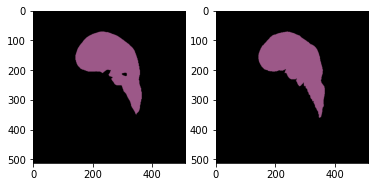

In [4]:
## tensor([-0.5175, -0.3556,  1.7958,  2.1399], device='cuda:0', requires_grad=True)

fusion_model.eval()
print(fusion_model.weights.weight)
input_tensor, mask = training_dataset.__getitem__(60)
input_batch = input_tensor.repeat(2, 1, 1, 1)
pred = fusion_model(input_batch.to(device))

final_func = nn.Sigmoid()
pred = final_func(pred).squeeze()
pred = torch.nn.functional.interpolate(pred.unsqueeze(0), size=512, mode="bilinear", align_corners=False).squeeze()
output_predictions = torch.round(pred[0])

# print(output_predictions.shape)
output_predictions = output_predictions.cpu().detach().squeeze()
output_predictions = np.round(output_predictions)
mask = mask.cpu().detach().squeeze()

palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(3)])[:, None] * 1.1 * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy())
r.putpalette(colors)

r_mask = Image.fromarray(mask.byte().cpu().numpy())
r_mask.putpalette(colors)

print(torch.max(output_predictions))
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(r)
plt.subplot(1, 2, 2)
plt.imshow(r_mask)
plt.show()